In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sample data
X = np.array([[1, 2], [3, 4], [5, 6]])

# Fit and transform the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Now, unscale it back
X_unscaled = X_scaled * scaler.scale_ + scaler.mean_

print("Original data:\n", X)
print("Scaled data:\n", X_scaled)
print("Unscaled data:\n", X_unscaled)

Original data:
 [[1 2]
 [3 4]
 [5 6]]
Scaled data:
 [[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]
Unscaled data:
 [[1. 2.]
 [3. 4.]
 [5. 6.]]


In [25]:
import os
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from matplotlib import pyplot as plt
from tqdm.contrib.concurrent import process_map

sns.set_theme()

In [26]:
def visualize_segment(file, is_test=False, first_10_sec=False):
    platform = str(file).split('\\')[-2]
    segment = pd.read_csv(file) 
    
    if is_test and first_10_sec:
        # Find the first index where steerCommand is NaN/None
        null_mask = segment['steerCommand'].isna()
        if null_mask.any():
            first_null_idx = null_mask.idxmax()
            segment = segment.iloc[1:first_null_idx]
    
    if not is_test:
        max_steering_angle = segment['steeringAngleDeg'].max()
        plots = [
            {'names': ['vEgo'], 'row': 0, 'col': 0, 'title': 'vEgo (m/s)'},
            {'names': ['aEgo'], 'row': 0, 'col': 1, 'title': 'aEgo (m/s^2)'},
            {'names': ['latAccelDesired', 'latAccelSteeringAngle', 'latAccelLocalizer'], 'row': 1, 'col': 0, 'title': 'Lateral Acceleration (m/s^2)'},
            {'names': ['steerFiltered', 'steer', 'latActive'], 'row': 1, 'col': 1, 'title': 'steer command [-1,1]'},
            {'names': ['steeringAngleDeg', ('steeringPressed', max_steering_angle)], 'row': 2, 'col': 0, 'title': 'Active states {0, 1}'},
            {'names': ['roll'], 'row': 2, 'col': 1, 'title': 'Road roll (rad)'},
            # {'names': ['latActive', 'steeringPressed'], 'row': 2, 'col': 1, 'title': 'Active states {0, 1}'},
        ]
    else:
        plots = [
            {'names': ['vEgo'], 'row': 0, 'col': 0, 'title': 'vEgo (m/s)'},
            {'names': ['aEgo'], 'row': 0, 'col': 1, 'title': 'aEgo (m/s^2)'},
            {'names': ['targetLateralAcceleration'], 'row': 1, 'col': 0, 'title': 'Lateral Acceleration (m/s^2)'},
            {'names': ['roll'], 'row': 1, 'col': 1, 'title': 'Road roll (rad)'},
            {'names': ['steerCommand'], 'row': 2, 'col': 0, 'title': 'steer command [-1,1]'},
        ]
        
    kwargs = {
        'alpha': 0.8,
    }
    fig, axs = plt.subplots(3, 2, figsize=(20, 10))
    for plot in plots:
        for name in plot['names']:
            if isinstance(name, tuple):
                scaled_pressed = segment[name[0]] * name[1]  # Scale by max steering angle
                axs[plot['row'], plot['col']].plot(segment['t'], scaled_pressed, label=f"{name[0]} (scaled)", **kwargs)
            else:
                axs[plot['row'], plot['col']].plot(segment['t'], segment[name], label=name, **kwargs)
        axs[plot['row'], plot['col']].set_title(plot.get('title'))
        axs[plot['row'], plot['col']].legend()
        
    plt.suptitle(f"Platform: {platform}; File: {file.name}")
    plt.tight_layout()
    plt.show()

def get_samples(files):
    dfs = process_map(pd.read_csv, files, max_workers=24, chunksize=100)
    df = pd.concat(dfs, ignore_index=True)
    return df, dfs
    

In [27]:
def check_nulls(df):
    null_counts = df.isna().sum()
    if null_counts.any():
        print("\nThe DataFrame contains null values.")
        print("Null counts per column:")
        print(null_counts)
    else:
        print("\nThe DataFrame has no null values.")

def print_min_max_values(df, is_test=False):
    print(f"Min speed (km/h): {min(df['vEgo']*3.6)}, Max speed (km/h): {max(df['vEgo']*3.6)}")
    print(f"Min speed (m/s): {min(df['vEgo'])}, Max speed (m/s): {max(df['vEgo'])}")
    if not is_test:
        print(f"Unique values in epsFwVersion: {df['epsFwVersion'].unique()}")
        print(f"Min lateral acceleration (m/s^2): {min(df['latAccelSteeringAngle'])}, Max lateral acceleration (m/s^2): {max(df['latAccelSteeringAngle'])}")
    else:
        print(f"Min lateral acceleration (m/s^2): {min(df['targetLateralAcceleration'])}, Max lateral acceleration (m/s^2): {max(df['targetLateralAcceleration'])}")
    
def count_row_frequencies(dfs, is_test=False):
    row_counts = [len(df) for df in dfs]
    frequency_counter = Counter(row_counts)
    freq_df = pd.DataFrame.from_dict(frequency_counter, orient='index', 
                                    columns=['Frequency']).sort_index()
    freq_df.index.name = 'Row Count'
    print(f"Frequency of row counts in {'Test' if is_test else 'Train'}:")
    print(freq_df)


In [28]:
train_path = pathlib.Path("../data/AUDI_A3_3RD_GEN")
test_path = pathlib.Path("../data/test")

train_files = list(train_path.glob("*.csv"))
test_files = list(test_path.glob("*.csv"))

train_df, train_dfs = get_samples(train_files)
test_df, test_dfs = get_samples(test_files)

100%|██████████| 20000/20000 [00:05<00:00, 3616.66it/s]


In [29]:
print(train_df.shape)
check_nulls(train_df)
print_min_max_values(train_df)

train_dfs[1].head()

(2098169, 13)

The DataFrame has no null values.
Min speed (km/h): -0.030231486048921483, Max speed (km/h): 163.48179510462904
Min speed (m/s): -0.0083976350135893, Max speed (m/s): 45.411609751285845
Unique values in epsFwVersion: ["b'\\xf1\\x875Q0909144T \\xf1\\x891072\\xf1\\x82\\x0521G00807A1'"
 "b'\\xf1\\x873Q0909144K \\xf1\\x895072\\xf1\\x82\\x0571G0HA16A1'"
 "b'\\xf1\\x875Q0909144R \\xf1\\x891061\\xf1\\x82\\x0516G00804A1'"
 "b'\\xf1\\x873Q0909144J \\xf1\\x895063\\xf1\\x82\\x0566G0HA14A1'"
 "b'\\xf1\\x875Q0909144P \\xf1\\x891043\\xf1\\x82\\x0503G0G803A0'"]
Min lateral acceleration (m/s^2): -12.999004575107156, Max lateral acceleration (m/s^2): 114.26867816597456


,vEgo,aEgo,steeringAngleDeg,steeringPressed,steer,steerFiltered,latActive,roll,t,latAccelSteeringAngle,latAccelDesired,latAccelLocalizer,epsFwVersion
0,34.216869,0.094610,-1.500000,False,-0.091882,-0.096624,True,0.047631,0.0,0.074533,0.108367,0.043404,b'\xf1\x875Q0909144T \xf1\x891072\xf1\x82\x052...
1,34.219597,0.079465,-1.501038,False,-0.127921,-0.116528,True,0.047643,0.1,0.074388,0.122928,0.056420,b'\xf1\x875Q0909144T \xf1\x891072\xf1\x82\x052...
2,34.216356,-0.004341,-1.600000,False,-0.093659,-0.100010,True,0.047655,0.2,0.102254,0.131026,0.069426,b'\xf1\x875Q0909144T \xf1\x891072\xf1\x82\x052...
3,34.233194,0.079043,-1.600000,False,-0.121139,-0.122594,True,0.047667,0.3,0.103180,0.142947,0.082478,b'\xf1\x875Q0909144T \xf1\x891072\xf1\x82\x052...
4,34.236193,0.082144,-1.599335,False,-0.068596,-0.070218,True,0.047640,0.4,0.100249,0.116359,0.076756,b'\xf1\x875Q0909144T \xf1\x891072\xf1\x82\x052...


In [30]:
print(test_df.shape)
check_nulls(test_df)
print_min_max_values(test_df, is_test=True)

test_dfs[1].head()

(11988342, 6)

The DataFrame contains null values.
Null counts per column:
t                                  0
vEgo                               0
aEgo                               0
roll                               0
targetLateralAcceleration          0
steerCommand                 9988342
dtype: int64
Min speed (km/h): -0.3603595848856873, Max speed (km/h): 154.33180851113036
Min speed (m/s): -0.1000998846904687, Max speed (m/s): 42.86994680864732
Min lateral acceleration (m/s^2): -260.1499347663047, Max lateral acceleration (m/s^2): 81.16634776955404


,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand
0,0.0,16.687496,-0.071339,0.022560,0.016600,0.114628
1,0.1,16.677579,-0.080744,0.022542,0.008503,0.120180
2,0.2,16.663720,-0.111154,0.022523,0.011581,0.117919
3,0.3,16.646755,-0.170391,0.022505,0.004863,0.122516
4,0.4,16.621532,-0.223756,0.022580,-0.002946,0.128522


In [31]:
# Initialize variables to track the minimum value and its location
min_lat_accel = -float('inf')
min_df_index = -1

# Iterate through each dataframe in test_dfs
for i, df in enumerate(test_dfs):
    current_min = df['targetLateralAcceleration'].max()
    if current_min > min_lat_accel:
        min_lat_accel = current_min
        min_df_index = i

# Print the result
print(f"Minimum 'targetLateralAcceleration' ({min_lat_accel}) is present in test_dfs[{min_df_index}]")

# Optionally, print details of the dataframe containing the minimum
if min_df_index != -1:
    print(f"\nDetails of test_dfs[{min_df_index}]:")
    print(test_dfs[min_df_index].shape)
    check_nulls(test_dfs[min_df_index])
    print_min_max_values(test_dfs[min_df_index], is_test=True)
    test_dfs[min_df_index].head()

Minimum 'targetLateralAcceleration' (81.16634776955404) is present in test_dfs[13735]

Details of test_dfs[13735]:
(586, 6)

The DataFrame contains null values.
Null counts per column:
t                              0
vEgo                           0
aEgo                           0
roll                           0
targetLateralAcceleration      0
steerCommand                 486
dtype: int64
Min speed (km/h): 48.09847366764126, Max speed (km/h): 53.89131956311406
Min speed (m/s): 13.360687129900349, Max speed (m/s): 14.969810989753904
Min lateral acceleration (m/s^2): -2.0460300816069674, Max lateral acceleration (m/s^2): 81.16634776955404


In [33]:
count_row_frequencies(train_dfs)
# count_row_frequencies(test_dfs, is_test=True)


Frequency of row counts in Train:
           Frequency
Row Count           
581                1
585                1
589                1
591                2
593                1
597                1
598               31
599             1727
600             1708
601               24
602                2
603                1


# Car acceleration, axis, rotation
![explaining](../imgs/explaining.png)


### Train:
| Название                  | Объяснение                                                                 | Типы значений               |
|-----------------------|---------------------------------------------------------------------------|-----------------------------|
| t                     | Время синхронизации замеров всех данных с частотой 10 Hz (0.1 секунда). Существует неточность в измерениях, которая отклоняется либо в большую, либо в меньшую сторону (0.09999 -> 0.199888 или 0.1000001 -> 0.2001110), но в конце сцены (60 секунд) погрешность не превышает 0.1 секунды, так что это не существенно и можно округлять до 0.1. Также не все сцены (по крайней мере тренировочные) имеют ровно 600 записей. Где-то больше, где-то меньше. Сегменты (один файл) никак не связаны между собой либо среди них прошло время, тк начальная скорость отличается от предыдущей финальной в предыдущем файле. Так как происходит синхронизация, могут происходить маскировки реальных задержек, но на это мы как ML специалист повлиять не можем. Также возможно некоторые сигналы интерполированы (точно не известно), что может привести к интерполяционным ошибкам | [0, 60] |
| steeringPressed       | Управляет ли водитель (юзер) рулем                        | `{True, False}` |
| latActive             | Используется ли автопилот (lateral control)                                         | `{True, False}` |
| vEgo                  | Передняя (продольная или longitudinal) скорость автомобиля. Странно, что нет сильной отрицательной скорости (походу нету ситуация с разворотом автомобиля из парковочного места). Точнее есть но очень близкая к нулю. Также есть сцены, где автомобиль стоит вначале или же в конце (возможно и в середине, например на светофорах), но таких данных не слишком уж много. Скорее всего характеристики рулевого управления сильно меняются в зависимости от скорости (нелинейность): На низких скоростях (парковка): большой угол поворота колёс при малом усилии. На высоких скоростях (шоссе): малый угол при том же усилии.                    | `[0, ∞]` |
| aEgo                  | Переднее (продольное или longitudinal) ускорение автомобиля (m/s^2)                | `[-∞, ∞]` |
| steeringAngleDeg      | Количество градусов (угол) на сколько руль повернут влево или вправо. По идее в зависимости от машины (платформы) будет отличаться и максимальный угол поворота руля.                     | `[-∞, ∞]` |
| steer                 | Нормализованный поворот руля автопилота, зависит от `latActive` = True (включен автопилот). `steer` берется обычно только тогда, когда человек не берет управление на себя (в основном на трассах), и там нету сильных поворотов. Из-за чего возникает ПРОБЛЕМА: нормализован он только в текущей сцене, то есть значения от -1 до 1 нормализуются по полученным маленьким градусам, а не по максимальному возможному повороту руля на платформе.  Дополнительно к этому существуют ситуации, когда включен контроллер (автопилот) и упрвление юзером одновременно. В данных ситуациях по идее `steer` отображает усилия автопилота, которые + к этому сопротивляются юзеру, из-за чего возникает нелинейность. Также существет проблема с переходом управления от юзера к автопилоту и наоборот. Это вызывает задержку (неизвестно сколько) и это влияет на данные, вызывая нелинейность в `steeringAngleDeg`. К тому же, замечено, что `steer` иногда выходит за промежутки от -1 до 1. Еще следует не забывать про задержки в управлении, тк сигнал от openpilot не моментально доходит до управления машиной: [OpenPilot] → [Пружина EPS] → [Демпфер рулевой рейки] → [Масса колёс]                     | `[-1, 1]` |
| steerFiltered         | То же самое, что и `steer`, только с ограничением скорости (не резких изменений). Более плавный сигнал, который приближен к реальному поведению машина из-за электроусилителя, который тоже сглаживает резкие изменения. | `[-1, 1]` |
| latAccelSteeringAngle | Боковое (lateral) ускорение, которое посчитано с помощью `steeringAngleDeg` и `roll`, используят модель машины из openpilot. Лучший сигнал, который можно использовать в трейне, тк больше всех приближен к реальности (рассчитывается по физике) и без шумов.   | `[-∞, ∞]` |
| latAccelLocalizer     | Боковое ускорение, которое измеряется с помощью датчика fusion localizer на устройстве comma three (возможно какой-то GPS, IMU). Имеет шум по сравнению с `latAccelSteeringAngle`, тк замеряется с приборами с погрешностью | `[-∞, ∞]` |
| latAccelDesired       | Желаемое боковое ускорение, которое запрошено от планировщика (planner, скорее всего автопилот), не совсем пересекается с реальностью, поэтому избегается в тренинге        | `[-∞, ∞]` |
| roll                  | Угол горизонтального поворота дороги                                        | `[-0.174, 0.174]` (radians)<br>`(-9.97, 9.97)` (degrees analog) |
| epsFwVersion          | Версия электроусилителя (EPS) в машине. Влияет на поведение управления, даже на одной платформе (модели автомобил), хотя это не частое явление                      | `str` |

Numerical: roll, aEgo, vEgo, latAccelSteeringAngle, 
steeringAngleDeg

### Test:
| t | vEgo | aEgo | roll | targetLateralAcceleration | steerCommand |
|---|------|------|------|---------------------------|--------------|

Где после 10 секунд `steerCommand` пропадает


### Замечания:

- Если самому нормализовывать steeringAngleDeg, то нужно учитывать, что для разных моделей будут разные значения, а для теста не понятно какая машина присутствует
- Что предиктить на тесте: управление только автопилота, управление всего (автопилот + юзер), или только юзера?
- Какова сущность проекта? Сделать полностью автономный беспилотник с только редкими ситуациями вмешательства от юзера (яндекс)? Или же сделать помощник на трассах, либо в других простых ситуциях? Данные существуют только для 2, тк для первого нету отрицательной скорости, для сдачи назад + отсуствуют некоторые другие инпуты, которые могут быть полезны.
- Проверить запаздалую реаецию опенпилота на управление машиной (на angular acceleration)

### Первая очередь
- Возможно есть пропуски по времени в данных
- Скейлить первые 10 секунд по максимальным значениям, а остальные по предыдущим и тренить модель.
- Если получится отследить файлы в их изначальной последовательности, то можно кратно увеличить датасет

- Нужно все нормализовывать
- При нормализации нужно учитывать, что возможны намного сильнее краевые значения (например ускорение очень огромным)
- Нужно нормализовывать отдельно по платформам или по всему?
- Нужно проанализировать поведение системы до/после вмешательства водителя, просмотреть артефакты, возможно восстановление управления от 0.5-3 секунд.
- Нужно посмотреть как выглядят вариации `epsFwVersion` и управление, скорее всего с одним eps и разной моделью автомобиля будет разное управление



- Проверить на нулы весь датасет (скорее всего таких нету, тк присутствует интерполяция. Если нулы есть, то интерполяция отсутствует)


### Идеи:

- Можно добавить метадату, например длину между осями колес, максимальные градусы разворота колес и руля, модель автомобиля
- Решение задачи: по 10 секундам предиктить следующие 50, или предиктить следующую секунду или что-то подобное
- Предиктить 2 головки: высокие скорости + слабые повороты (трасса, в основном автопилот) и маленькие скорости и сильные повороты (в основном человек) 
- Нужно попробовать препроцессить данные, с помощью раздельных скоростных режимов движения, мб удалять промежутки после перехвата управления, либо как-то по-другому обрабатывать временные задержки
- Возможно нужна аугментация, тк данных слишком много 750 000 сцен по 60 секунд, 
- Предиктить все 40 по 20 секундам
- Тренировать модель на части теста



### Questions:

- Почему скорость всегда положительная? Машина вообще не едет назад? 
- К сожалению не представлены остальные желательные данные (yaw - можно выразить из данных, pitch - не известно), тк от наклона автомобиля зависит его скорость 
- Странно, что нет данных для педалей 
- Какая машина на тесте?



- `steerCommand` в тесте не ограничена -1 и 1, по влиянию на lateral acceleration она похожа на steeringAngleDeg. В тесте скейлинг для каждой сцены свой, значит и для трейна нужно делать также. Причем в известных данных значения steerCommand тоже выходят за границы.
- `steer` - усилия только автопилота
- не во всех файлах ровно 600 эпизодов (в тесте где-то даже 400), то есть нужно либо предиктить основываясь только на 1 строчке + память, или предиктить на много сразу имея набор данных. По идее правильней первый вариант, тк мы в реальности не знаем все что может измениться на несколько шагов вперед
- и в трейне и в тесте есть слегка отрицательные скорости (чуть меньше нуля), но действительно сильных отрицательных значений нету.
- почему-то в начале (первая строчка) некоторых файлов `targetLateralAcceleration` очень большой или маленький (-260.1 и 81.2), это какая-то ошибка тк даже гоночные тачки на идеальном треке редко набирают больше 15m/s^2, а длительное ускорение выше ~50 m/s² может привести к потере сознания. Нужно разобраться и убирать эти значения, если есть

In [10]:
# strange_ids = [33, 1110, 3384]
# visualize_segment(files[1110])

In [11]:
# ACC_G = 9.81


# # conside only samples where openpilot is driving (latActive and not steeringPressed)
# df = df[(df['latActive'])&(~df['steeringPressed'])]

# plt.figure(figsize=(10,10))

# # The convention we use is -ve steer
# plt.scatter(-df['steerFiltered'], df['latAccelSteeringAngle'] - np.sin(ACC_G * df['roll']), s=0.1, alpha=0.1)
# plt.xlabel("Steer command [-1, 1]")
# plt.ylabel("Lateral Acceleration (m/s^2)")
# plt.ylim(-4, 4)
# plt.title("Lateral Acceleration (adjusted for gravity) vs steer command (only when openpilot is active)")
# plt.show()

In [12]:
strange_ids = [33, 1110, 3384, 2949, 1, 6, 2840, 2841, 2842]
strange_id = strange_ids[3]
strange_id = 11714

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap



num = strange_id 
dfsample = pd.concat(test_dfs[num:num+1], ignore_index=True)
vEgo = dfsample['vEgo'].values
# latAccel = dfsample['latAccelSteeringAngle'].values
latAccel = dfsample['targetLateralAcceleration'].values
roll = dfsample['roll'].values
# vEgo = dfs[num]['vEgo']
# steeringAngleDeg = dfs[num]['latAccelDesired']

# Constants
wheelbase = 2.67  # м (пример для Toyota Corolla)
dt = 0.1  # временной шаг
g = 9.81
marker_interval = 1
color_interval = 10 * marker_interval
epsilon = 1e-3

# Initialize
x_coords, y_coords = [0], [0]
x, y, theta = 0, 0, 0
marker_indices = []  # To store indices where we'll place markers
segment_starts = []  # For color segments

# Create colormap with distinct colors
colors = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])

for t in range(len(vEgo)):
    v = vEgo[t]
    a_lat = latAccel[t]
    if v < 0.1:  # Avoid division near zero
        x_coords.append(x)
        y_coords.append(y)
        continue
    
    curvature = a_lat / (v**2 + epsilon)  # кривизна траектории
    delta_theta = v * curvature * dt  # изменение угла направления
    theta += delta_theta
    
    dx = v * np.cos(theta) * dt
    dy = v * np.sin(theta) * dt
    x += dx
    y += dy
    x_coords.append(x)
    y_coords.append(y)
    
    current_time = t * dt
    if abs(current_time % marker_interval) < dt:
        marker_indices.append(len(x_coords) - 1)
    if abs(current_time % color_interval) < dt:
        segment_starts.append(len(x_coords) - 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


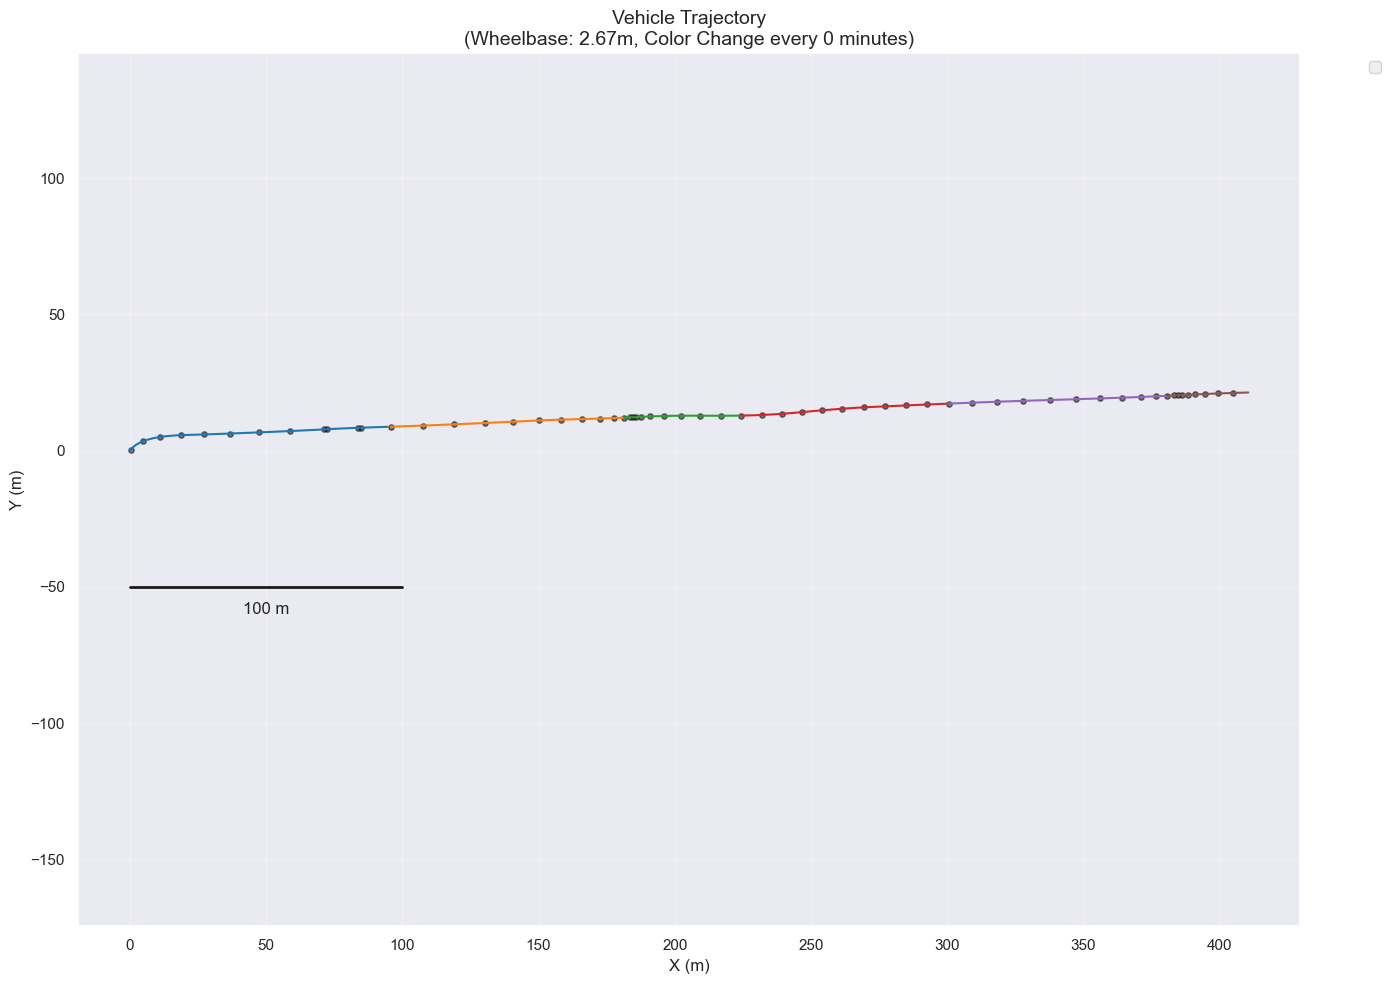

In [14]:
plt.figure(figsize=(14, 10))

# Plot colored segments
segment_starts.append(len(x_coords))  # Add end point
for i in range(len(segment_starts)-1):
    start = segment_starts[i]
    end = segment_starts[i+1]
    color = colors(i % colors.N)
    plt.plot(x_coords[start:end], y_coords[start:end], 
             color=color, linewidth=1.5)

# Plot markers (smaller and semi-transparent)
plt.scatter([x_coords[i] for i in marker_indices],
            [y_coords[i] for i in marker_indices],
            c='black', s=15, alpha=0.5, marker='o')

plt.xlabel("X (m)", fontsize=12)
plt.ylabel("Y (m)", fontsize=12)
plt.title(f"Vehicle Trajectory\n(Wheelbase: {wheelbase}m, Color Change every {color_interval//60} minutes)", 
          fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.axis("equal")

# Add scale bar
plt.plot([0, 100], [min(y_coords)-50, min(y_coords)-50], 'k-', lw=2)
plt.text(50, min(y_coords)-60, "100 m", ha='center')

plt.tight_layout()
plt.show()

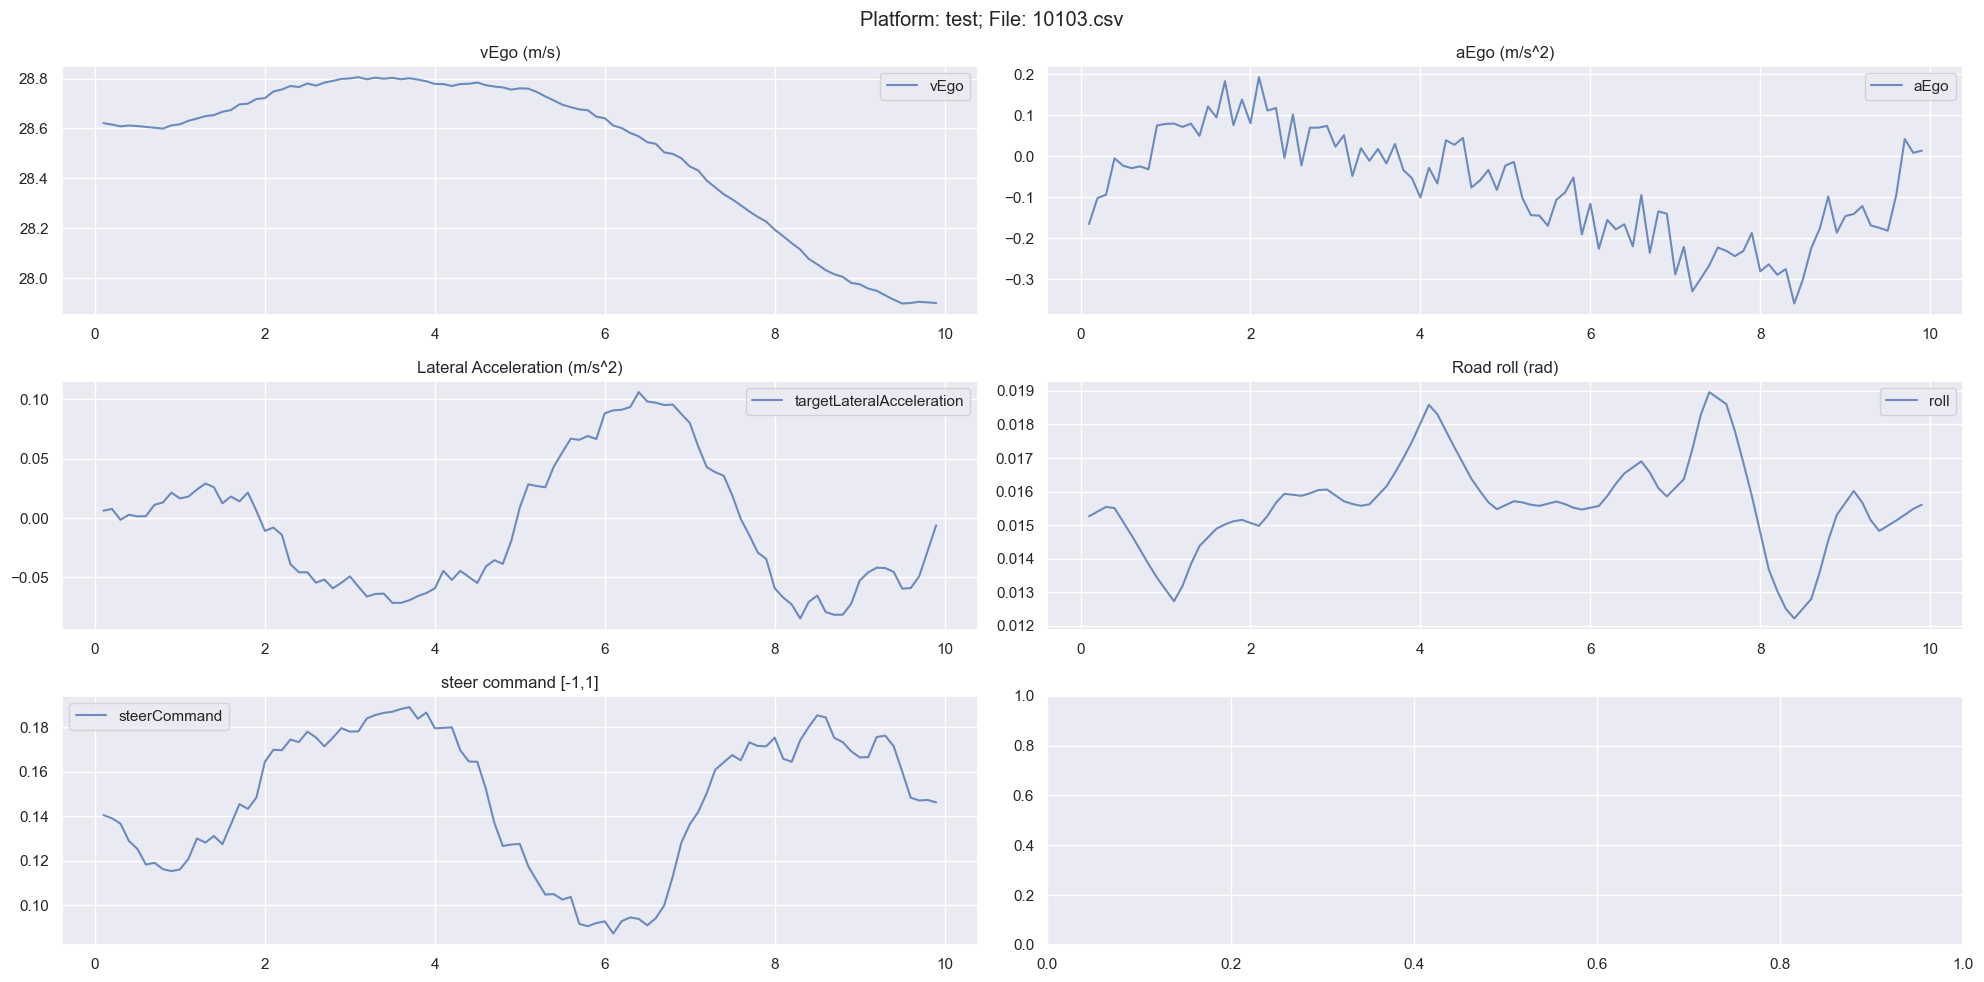

In [24]:
# visualize_segment(test_files[11714], is_test=True, first_10_sec=True)
# visualize_segment(test_files[10101], is_test=True, first_10_sec=True)
visualize_segment(test_files[10103], is_test=True, first_10_sec=True)
# visualize_segment(train_files[0])
